In [339]:
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units as u, constants as const
from astropy.cosmology import Planck18
import utils1
import time as time
import emcee
import corner
from multiprocessing import Pool

# Creating clusters

In [340]:
run functions.py

In [341]:
N_cells = 120 # number of cells of grid for convergence map
Lbox = 5. * u.Mpc
hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
xedges = np.linspace(-hext, hext, N_cells+1)
yedges = np.linspace(-hext, hext, N_cells+1)
xs = 0.5*(xedges[1:]+xedges[:-1])
ys = 0.5*(yedges[1:]+yedges[:-1])
xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
cosmo = astropy.cosmology.Planck18

In [342]:
z_lens1 = 0.071806
z_source1 = 0.1609
x1 = 0 # Mpc
y1 = -1.6 # Mpc
Dl1 = cosmo.angular_diameter_distance(z_lens1)

A399 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x1, y0=y1, c=1.013, M=8.7E14, z_lens=z_lens1, z_source=z_source1)

In [343]:
z_lens2 = 0.073664
z_source2 = 0.1609
x2 = 0 # Mpc
y2 = 1.6 # Mpc
Dl2 = cosmo.angular_diameter_distance(z_lens2)

A401 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x2, y0=y2, c=1.109, M=10.2E14, z_lens=z_lens2, z_source=z_source2)

In [344]:
np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))

3.2

In [345]:
combined_kappa = A399 + A401

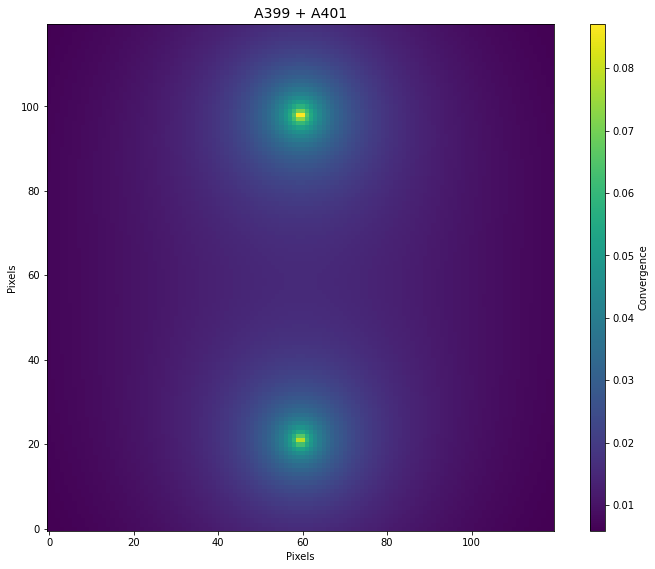

In [346]:
utils1.plot_image(image=combined_kappa, title='A399 + A401', interval_type='simple_norm', cbar_label="Convergence")

# Creating filament

In [347]:
# redshift: z = 0.072735
# length: 12.3 arcmin / 2.2 Mpc
# width: 10.9 arcmin / 1.9 Mpc
# density: 0.88 × 10−4 cm^-3

In [348]:
# critical surface density
def fil_critial_dens(z_lens=0.072735, z_source=0.1609, cosmology=Planck18):
    Ds = cosmology.angular_diameter_distance(z_source)
    Dl = cosmology.angular_diameter_distance(z_lens)
    Dls = cosmology.angular_diameter_distance_z1z2(z_lens,z_source)
    sig_crit = (const.c**2/(4*np.pi*const.G))*Ds/(Dl*Dls) 
    
    return sig_crit.to(u.solMass/u.Mpc**2)

def filament(xgrid, ygrid, x0, y0, l, w, z_lens=0.072735, z_source=0.1609, smd=7.89e13):
    """
    xgrid: (numpy array 2D)
    ygrid: (numpy array 2D)
    x0: (float) center of the grid in x [Mpc]
    y0: (float) center of the grid in y [Mpc]
    offset: vertical offset of center position 
    z_lens: (float) redshift of the lens (filament)
    z_source: (float) redshift of the background source
    M: (float) filament mass [solar masses]
    """
    l = l/2
    w = w/2
    
    smd *= u.solMass/u.Mpc**2 # solar masses
    critical_surf_dens = fil_critial_dens(z_lens=z_lens,z_source=z_source) # solar mass / Mpc^2
    amp = smd / critical_surf_dens # unitless
    
    # Convert grid to r
    r = np.zeros(xgrid.shape)
    
    l_arr = np.sqrt(((ygrid-y0))**2)
    w_arr = np.sqrt(((xgrid-x0))**2)  
    
    for i in range(len(r)):
        for j in range(len(r)):
            r[i][j] = amp / (1 + (l_arr[i][j]/l)**8 + (w_arr[i][j]/w)**8)
            
    return r

In [349]:
mass = 3.3e14 # solar masses
a = 2.2 * 1.9
surf_mass_dens = mass / a

In [350]:
np.format_float_scientific(surf_mass_dens)

'7.894736842105264e+13'

In [351]:
fil = filament(xgrid=xgrid, ygrid=ygrid, x0=0.2, y0=0.2, l=2.2, w=1.9, z_lens=0.072735, z_source=0.1609, smd=7.89e13)

In [352]:
#plt.plot(fil)

In [353]:
N_cells = 120 # number of cells of grid for convergence map
Lbox = 5. * u.Mpc
hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
xedges = np.linspace(-hext, hext, N_cells+1)
yedges = np.linspace(-hext, hext, N_cells+1)
xs = 0.5*(xedges[1:]+xedges[:-1])
ys = 0.5*(yedges[1:]+yedges[:-1])
xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
cosmo = astropy.cosmology.Planck18

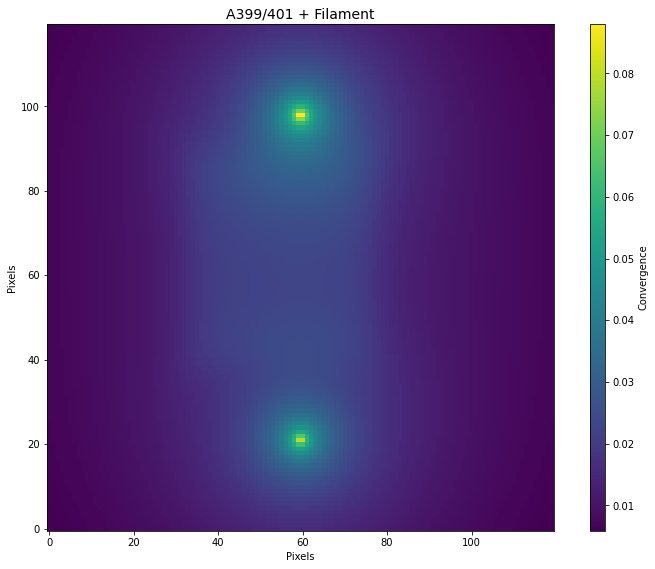

In [354]:
utils1.plot_image(image=combined_kappa + fil, title='A399/401 + Filament', interval_type='simple_norm', cbar_label="Convergence")

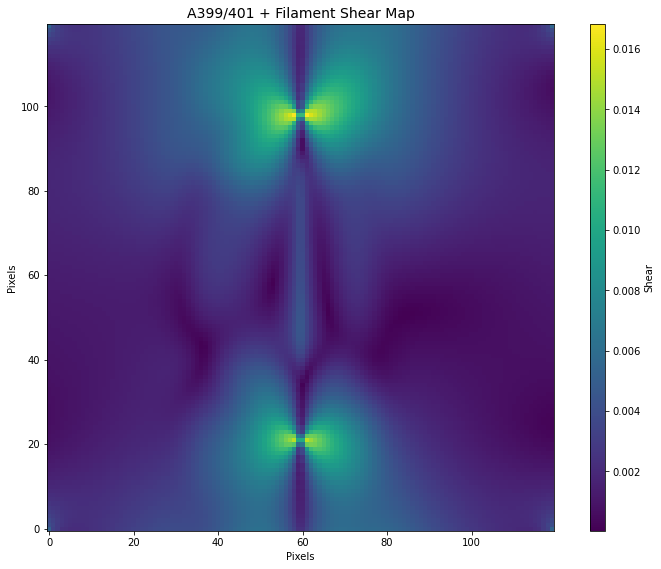

In [361]:
utils1.plot_image(image=abs(shear_from_kappa(combined_kappa + fil)), title='A399/401 + Filament Shear Map', interval_type='simple_norm', cbar_label="Shear")

# MCMC of just fil

In [258]:
def get_init(nwalkers):
    """ creates a list of initial values nwalkers long 
    """
    smd = np.random.uniform(low=5e13, high=11e13, size=nwalkers) # 7.89e13
    l = np.random.uniform(low=0.1, high=3, size=nwalkers) # 2.2
    w = np.random.uniform(low=0.1, high=3, size=nwalkers) # 1.9
    x0 = np.random.uniform(low=-1, high=1, size=nwalkers) # 0.2
    y0 = np.random.uniform(low=-1, high=1, size=nwalkers) # 0.2
    
    p0 = []
    for i in range(nwalkers):
        p0.append(np.array([smd[i], l[i], w[i], x0[i], y0[i]]))
    return np.array(p0)

def log_prior(x):
    """ checking the guess is within range
    """
    smd, l, w, x0, y0 = x
    if not ((5e13 < smd < 11e13) and (0.1 < l < 3) and (0.1 < w < 3) and (-1 < x0 < 1) and (-1 < y0 < 1)):
        return -np.inf
    return 0.0

def log_prob(x, fil_input: np.ndarray, sigma: float):
    """ x = p0 (initial guesses in the format of [(smd, l, w, x0, y0) * 50])
        sigma = std of cluster
    """ 
    smd, l, w, x0, y0 = x
    
    # Check prior
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    
    # Set values
    N_cells = 120 # number of cells of grid for convergence map
    Lbox = 5. * u.Mpc
    hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
    xedges = np.linspace(-hext, hext, N_cells+1)
    yedges = np.linspace(-hext, hext, N_cells+1)
    xs = 0.5*(xedges[1:]+xedges[:-1])
    ys = 0.5*(yedges[1:]+yedges[:-1])
    xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')# Create filament
    fil = filament(xgrid=xgrid, ygrid=ygrid, x0=x0, y0=y0, l=l, w=w, z_lens=0.072735, z_source=0.1609, smd=smd)
    
    # Create kappa and gamma maps
    kappa = fil
    gamma_model = shear_from_kappa(kappa)
    gamma_obs = fil_input
    
    # Calculate residuals
    resid_real = (np.square(gamma_obs.real - gamma_model.real)) # 2D array
    resid_imag = (np.square(gamma_obs.imag - gamma_model.imag)) # 2D array
    term1 = np.sum(resid_real) # float
    term2 = np.sum(resid_imag) # float

    return -0.5 * (term1 + term2) / (sigma**2.) # float

In [259]:
fil_shear = shear_from_kappa(kappa=fil)

In [260]:
nwalkers = 50
ndim = 5
p0 = get_init(nwalkers)

In [261]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[fil_shear + np.random.normal(0,0.01,np.shape(fil_shear)), 0.01])
    sampler.run_mcmc(p0, 100, progress=True)

100%|██████████| 100/100 [12:56<00:00,  7.76s/it]


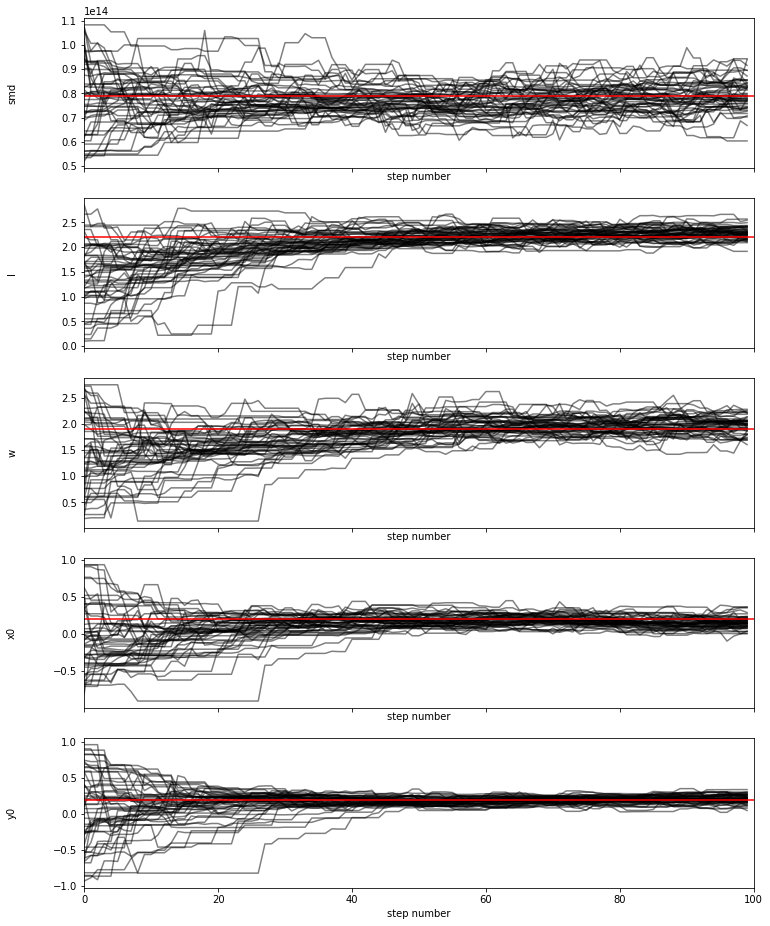

In [262]:
fig, axes = plt.subplots(5, figsize=(12, 16), sharex=True)
samples = sampler.get_chain()
labels = ["smd", "l", "w", "x0", "y0"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color="k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number")
    if(i == 0):
        ax.axhline(7.89e13, color='r',alpha=1)
    elif i == 1:
        ax.axhline(2.2, color='r',alpha=1)
    elif i == 2:
        ax.axhline(1.9, color='r',alpha=1)
    elif i == 3:
        ax.axhline(0.2, color='r',alpha=1)
    elif i == 4:
        ax.axhline(0.2, color='r',alpha=1)

burn-in: 23
thin: 4


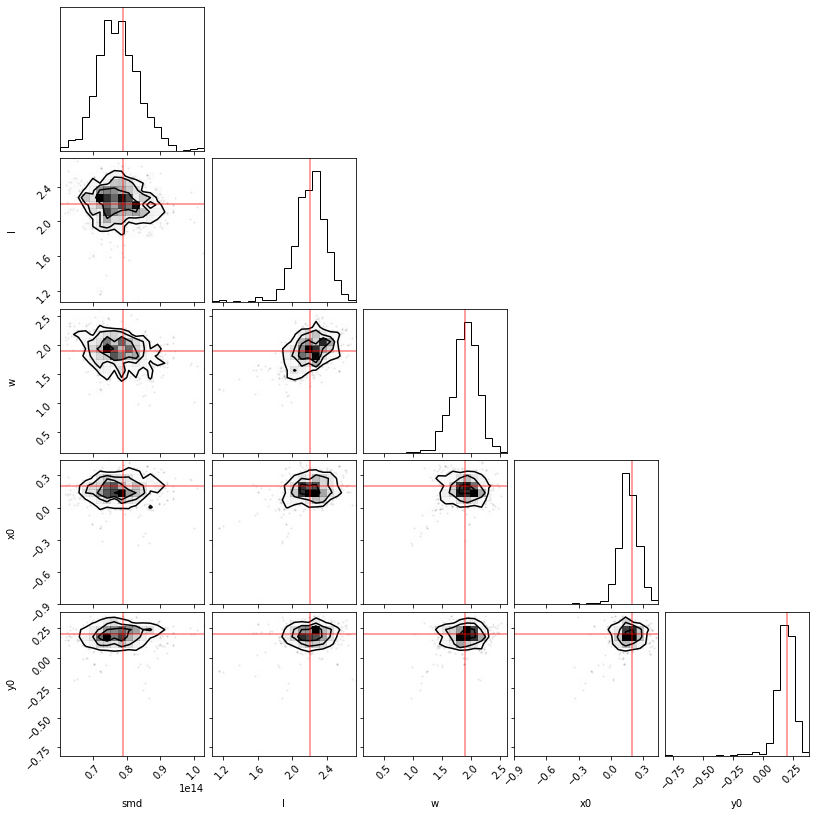

In [264]:
tau = [ 9.37218646, 11.95704568, 11.34403488, 10.69760734, 9.44812546] #sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=False, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

all_samples = np.concatenate(samples)

labels = ['smd', 'l', 'w', 'x0', 'y0']

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[7.89e13, 2.2, 1.9, 0.2, 0.2], color='red', alpha=0.5)